In [344]:
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ, opflow
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
import qiskit.quantum_info as qi
from qiskit.providers.aer import AerSimulator
from qiskit.result import Result
from qiskit.providers.aer.noise import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from scipy.optimize import minimize
from qiskit.opflow import Gradient
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-12-28 12:55:53,236: Credentials are already in use. The existing account in the session will be replaced.


In [345]:
theta = Parameter('θ')
n=4 #number of qubits
delay= Parameter('d')
qreg_q = QuantumRegister(n, 'q')
def binseq(k):
    return [''.join(x) for x in itertools.product('01', repeat=k)]

##Circuit Components

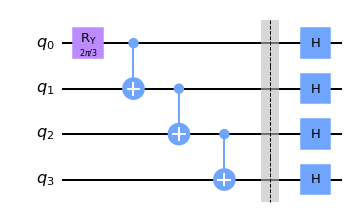

In [346]:
U_prep = QuantumCircuit(qreg_q)
U_prep.ry(2 * np.pi / 3, qreg_q[0])
for i in range(0,n-1):
    U_prep.cx(qreg_q[i], qreg_q[i+1])
U_prep.barrier()
for i in range(0,n):
    U_prep.h(qreg_q[i])
U_prep.draw()

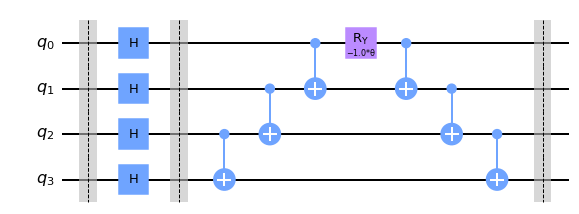

In [347]:
B_dag = QuantumCircuit(qreg_q)
B_dag.barrier()
for i in range(0,n):
    B_dag.h(qreg_q[i])
B_dag.barrier()
for i in range(n,1,-1):
    B_dag.cx(qreg_q[i-2], qreg_q[i-1])
B_dag.ry(-theta, qreg_q[0])
for i in range(0,n-1):
    B_dag.cx(qreg_q[i], qreg_q[i+1])
B_dag.barrier()
B_dag.draw()

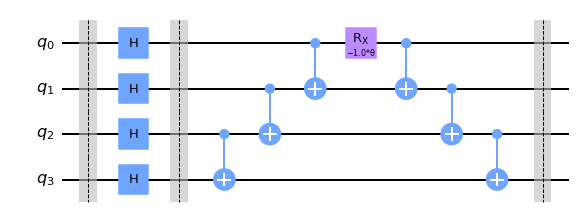

In [348]:
B_dag_rx = QuantumCircuit(qreg_q)
B_dag_rx.barrier()
for i in range(0,n):
    B_dag_rx.h(qreg_q[i])
B_dag_rx.barrier()
for i in range(n,1,-1):
    B_dag_rx.cx(qreg_q[i-2], qreg_q[i-1])
B_dag_rx.rx(-theta, qreg_q[0])
for i in range(0,n-1):
    B_dag_rx.cx(qreg_q[i], qreg_q[i+1])
B_dag_rx.barrier()
B_dag_rx.draw()

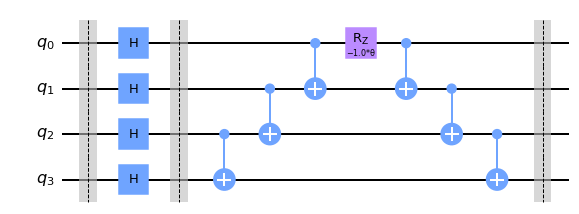

In [349]:
B_dag_rz = QuantumCircuit(qreg_q)
B_dag_rz.barrier()
for i in range(0,n):
    B_dag_rz.h(qreg_q[i])
B_dag_rz.barrier()
for i in range(n,1,-1):
    B_dag_rz.cx(qreg_q[i-2], qreg_q[i-1])
B_dag_rz.rz(-theta, qreg_q[0])
for i in range(0,n-1):
    B_dag_rz.cx(qreg_q[i], qreg_q[i+1])
B_dag_rz.barrier()
B_dag_rz.draw()

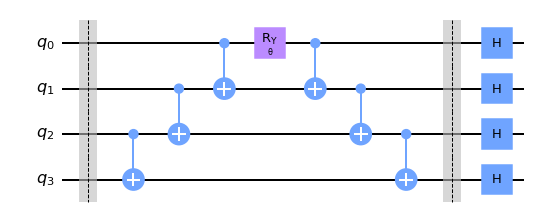

In [350]:
B = QuantumCircuit(qreg_q)
B.barrier()
for i in range(n,1,-1):
    B.cx(qreg_q[i-2], qreg_q[i-1])
B.ry(theta, qreg_q[0])
for i in range(0,n-1):
    B.cx(qreg_q[i], qreg_q[i+1])
B.barrier()
for i in range(0,n):
    B.h(qreg_q[i])
B.draw()

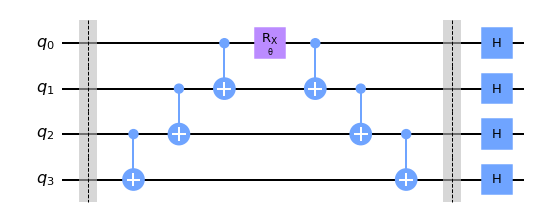

In [351]:
B_rx = QuantumCircuit(qreg_q)
B_rx.barrier()
for i in range(n,1,-1):
    B_rx.cx(qreg_q[i-2], qreg_q[i-1])
B_rx.rx(theta, qreg_q[0])
for i in range(0,n-1):
    B_rx.cx(qreg_q[i], qreg_q[i+1])
B_rx.barrier()
for i in range(0,n):
    B_rx.h(qreg_q[i])
B_rx.draw()

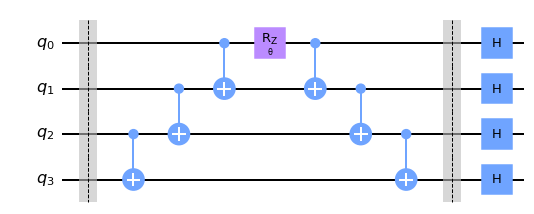

In [352]:
B_rz = QuantumCircuit(qreg_q)
B_rz.barrier()
for i in range(n,1,-1):
    B_rz.cx(qreg_q[i-2], qreg_q[i-1])
B_rz.rz(theta, qreg_q[0])
for i in range(0,n-1):
    B_rz.cx(qreg_q[i], qreg_q[i+1])
B_rz.barrier()
for i in range(0,n):
    B_rz.h(qreg_q[i])
B_rz.draw()

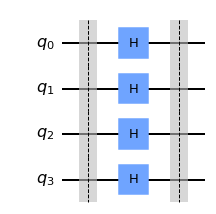

In [353]:
D = QuantumCircuit(qreg_q)
D.barrier()
for i in range(0,n):
    D.h(qreg_q[i])
D.barrier()
D.draw()

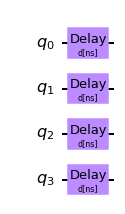

In [354]:
Delay = QuantumCircuit(qreg_q)
Delay.delay(delay,unit='ns')
Delay.draw()

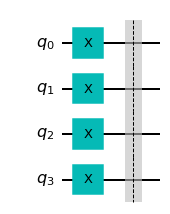

In [355]:
X = QuantumCircuit(qreg_q)
for i in range(n):
    X.x(qreg_q[i])
X.barrier()
X.draw()

##Preparing psi_in

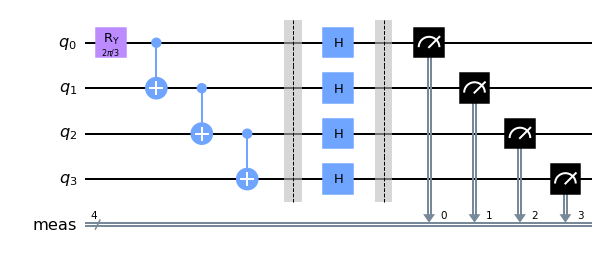

In [356]:
circuit1=U_prep.copy('circuit1')
circuit1.measure_all()
circuit1.draw()

In [357]:
backend = Aer.get_backend('aer_simulator')
counts = backend.run(circuit1, shots=1024).result().get_counts()

##Fidelity without using Collective-Collective Scheme

/tmp/ipykernel_77/2993437126.py:1: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuit2=U_prep+Delay


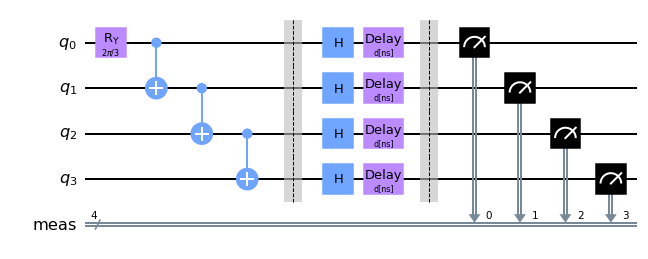

In [358]:
circuit2=U_prep+Delay
circuit2.measure_all()
circuit2.draw()

[]

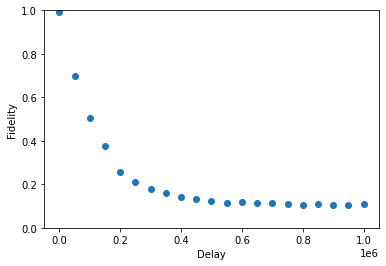

In [359]:
def d_vs_fidelity(d1):
    T1 = 108510 # in ns
    T2 = 96080 # considering T2 = T1, since it is not very important here
    noise_model = NoiseModel()
    err = thermal_relaxation_error(T1,T2,d1)
    noise_model.add_all_qubit_quantum_error(err,'delay','cx')
    backend = AerSimulator(noise_model=noise_model)
    counts1 = backend.run(circuit2.assign_parameters({delay : d1}),shots=1024).result().get_counts()
    sum=0.0
    for x in binseq(n):
        temp=counts[x]/1024 if (x in counts.keys()) else 0
        temp=temp*(counts1[x]/1024 if (x in counts1.keys()) else 0)
        sum=sum+math.sqrt(temp)
    return (sum*sum)

d=0
d_vs_fid1 = dict()
while d<=1e06:
    d_vs_fid1.update({d : d_vs_fidelity(d)})
    d=d+50000
plt.scatter(list(d_vs_fid1.keys()),list(d_vs_fid1.values()))
plt.xlabel('Delay')
plt.ylabel('Fidelity')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.plot()

$$Collective-Collective \hspace{0.2cm}[Using R_{Y}(\theta)] $$

/tmp/ipykernel_77/1248946417.py:1: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuit20=U_prep+X+B_dag+Delay+B+X


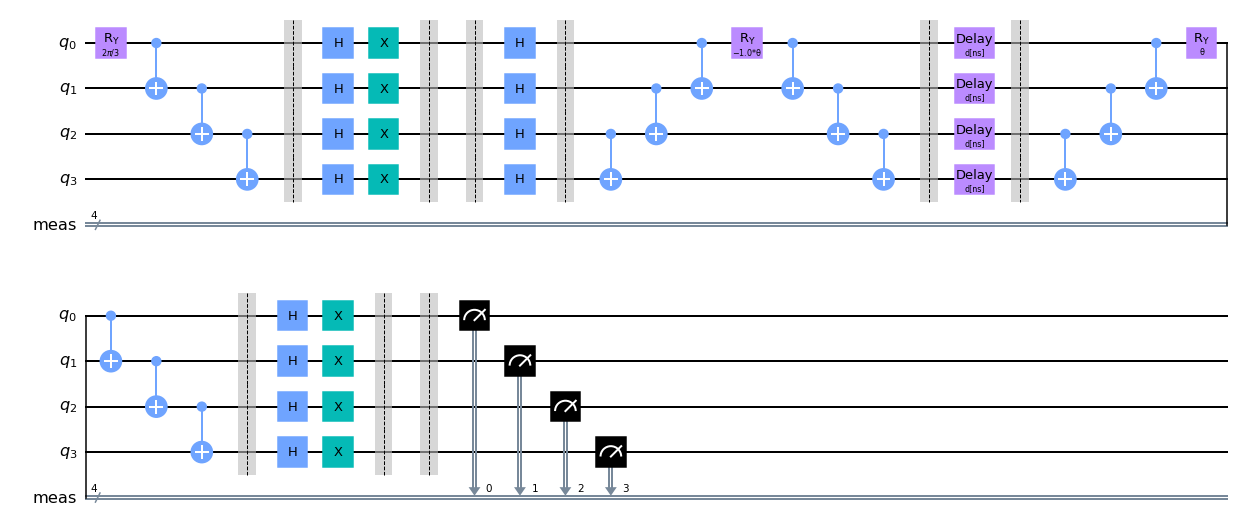

In [360]:
circuit20=U_prep+X+B_dag+Delay+B+X
circuit20.measure_all()
circuit20.draw()

[]

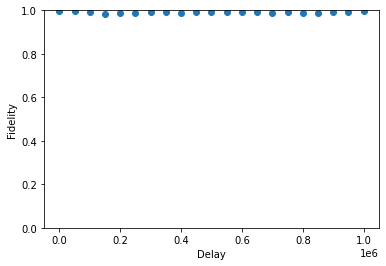

In [361]:
def d_vs_fidelity(d1):
    T1 = 108510 # in ns
    T2 = 96080 # considering T2 = T1, since it is not very important here
    noise_model = NoiseModel()
    err = thermal_relaxation_error(T1,T2,d1)
    noise_model.add_all_qubit_quantum_error(err,'delay','cx')
    def evaluate_fidelity(theta1):
        backend = AerSimulator(noise_model=noise_model)
        counts1 = backend.run(circuit20.assign_parameters({delay : d1, theta: theta1[0]}),shots=1024).result().get_counts()
        sum=0.0
        for x in binseq(n):
            temp=counts[x]/1024 if (x in counts.keys()) else 0
            temp=temp*(counts1[x]/1024 if (x in counts1.keys()) else 0)
            sum=sum+math.sqrt(temp)
        return -(sum*sum)
    initial_point = np.random.random(circuit20.num_parameters)
    return -minimize(evaluate_fidelity, initial_point, method='COBYLA')['fun']


d=0
d_vs_fid2 = dict()
while d<=1e06:
    d_vs_fid2.update({d : d_vs_fidelity(d)})
    d=d+50000
plt.scatter(list(d_vs_fid2.keys()),list(d_vs_fid2.values()))
plt.xlabel('Delay')
plt.ylabel('Fidelity')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.plot()

$$Collective-Collective \hspace{0.2cm}[Using R_{X}(\theta)] $$

/tmp/ipykernel_77/2566057548.py:1: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuit20=U_prep+X+B_dag_rx+Delay+B_rx+X


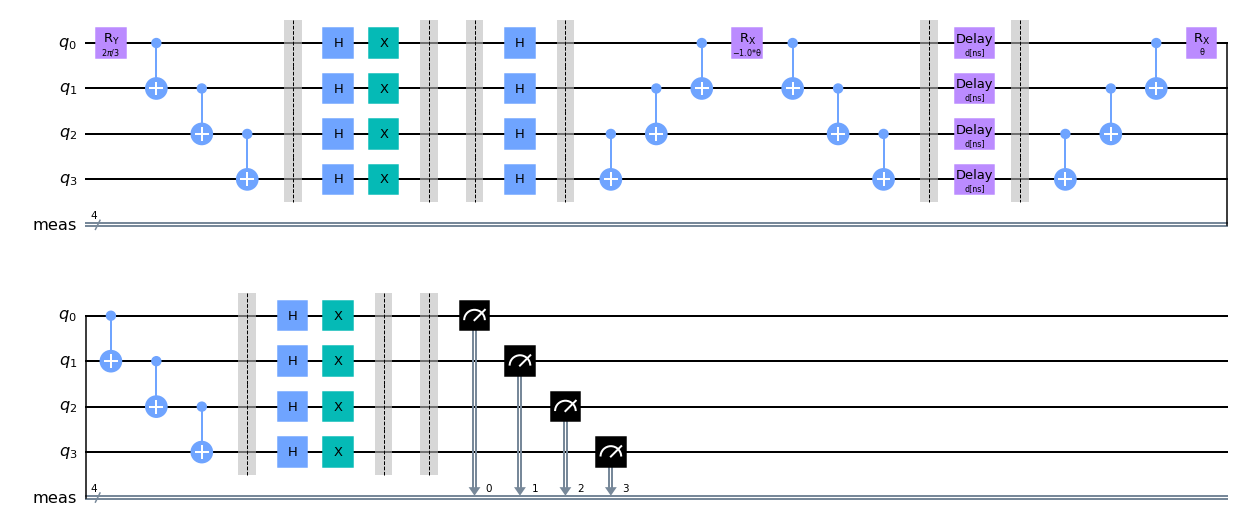

In [362]:
circuit20=U_prep+X+B_dag_rx+Delay+B_rx+X
circuit20.measure_all()
circuit20.draw()

[]

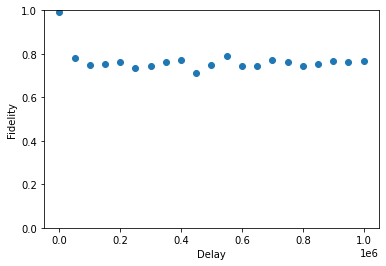

In [363]:
def d_vs_fidelity(d1):
    T1 = 108510 # in ns
    T2 = 96080 # considering T2 = T1, since it is not very important here
    noise_model = NoiseModel()
    err = thermal_relaxation_error(T1,T2,d1)
    noise_model.add_all_qubit_quantum_error(err,'delay','cx')
    def evaluate_fidelity(theta1):
        backend = AerSimulator(noise_model=noise_model)
        counts1 = backend.run(circuit20.assign_parameters({delay : d1, theta: theta1[0]}),shots=1024).result().get_counts()
        sum=0.0
        for x in binseq(n):
            temp=counts[x]/1024 if (x in counts.keys()) else 0
            temp=temp*(counts1[x]/1024 if (x in counts1.keys()) else 0)
            sum=sum+math.sqrt(temp)
        return -(sum*sum)
    initial_point = np.random.random(circuit20.num_parameters)
    return -minimize(evaluate_fidelity, initial_point, method='COBYLA')['fun']


d=0
d_vs_fid3 = dict()
while d<=1e06:
    d_vs_fid3.update({d : d_vs_fidelity(d)})
    d=d+50000
plt.scatter(list(d_vs_fid3.keys()),list(d_vs_fid3.values()))
plt.xlabel('Delay')
plt.ylabel('Fidelity')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.plot()

$$Collective-Collective \hspace{0.2cm}[Using R_{Z}(\theta)] $$

/tmp/ipykernel_77/1052920930.py:1: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuit20=U_prep+X+B_dag_rz+Delay+B_rz+X


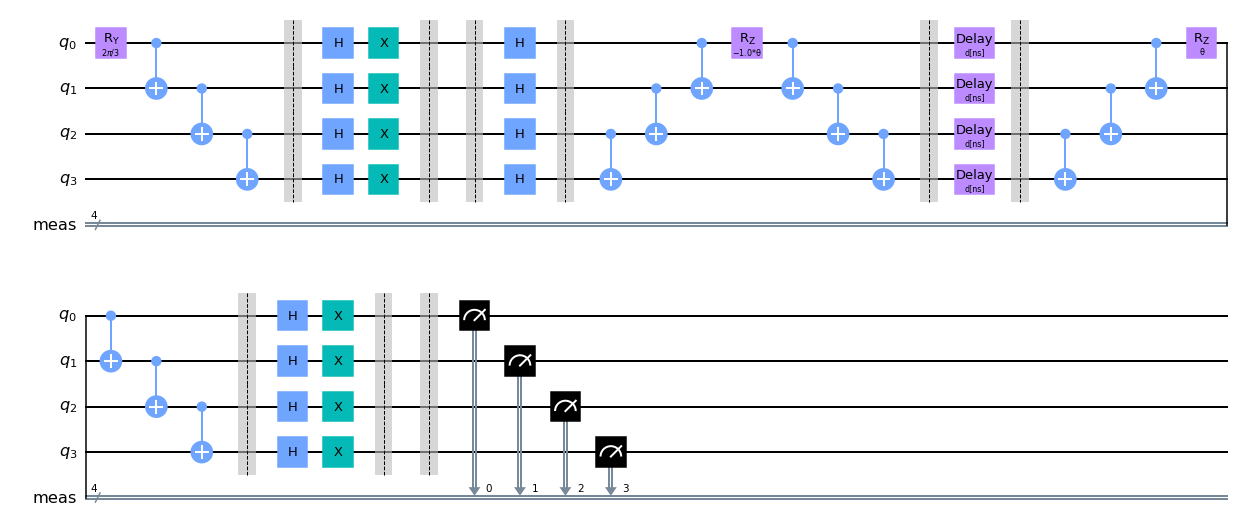

In [364]:
circuit20=U_prep+X+B_dag_rz+Delay+B_rz+X
circuit20.measure_all()
circuit20.draw()

[]

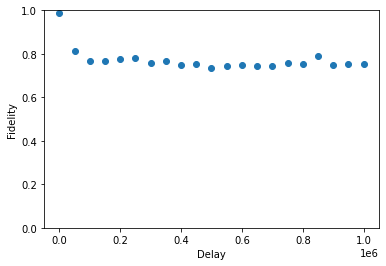

In [365]:
def d_vs_fidelity(d1):
    T1 = 108510 # in ns
    T2 = 96080 # considering T2 = T1, since it is not very important here
    noise_model = NoiseModel()
    err = thermal_relaxation_error(T1,T2,d1)
    noise_model.add_all_qubit_quantum_error(err,'delay','cx')
    def evaluate_fidelity(theta1):
        backend = AerSimulator(noise_model=noise_model)
        counts1 = backend.run(circuit20.assign_parameters({delay : d1, theta: theta1[0]}),shots=1024).result().get_counts()
        sum=0.0
        for x in binseq(n):
            temp=counts[x]/1024 if (x in counts.keys()) else 0
            temp=temp*(counts1[x]/1024 if (x in counts1.keys()) else 0)
            sum=sum+math.sqrt(temp)
        return -(sum*sum)
    initial_point = np.random.random(circuit20.num_parameters)
    return -minimize(evaluate_fidelity, initial_point, method='COBYLA')['fun']


d=0
d_vs_fid4 = dict()
while d<=1e06:
    d_vs_fid4.update({d : d_vs_fidelity(d)})
    d=d+50000
plt.scatter(list(d_vs_fid4.keys()),list(d_vs_fid4.values()))
plt.xlabel('Delay')
plt.ylabel('Fidelity')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.plot()

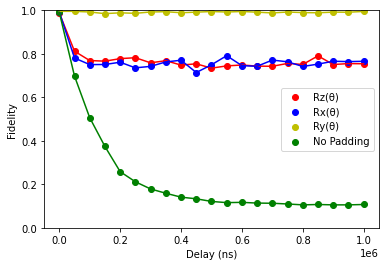

In [366]:
plt.scatter(list(d_vs_fid4.keys()),list(d_vs_fid4.values()), c='r', label='Rz(θ)')
plt.scatter(list(d_vs_fid3.keys()),list(d_vs_fid3.values()), c='b', label='Rx(θ)')
plt.scatter(list(d_vs_fid2.keys()),list(d_vs_fid2.values()), c='y', label='Ry(θ)')
plt.scatter(list(d_vs_fid1.keys()),list(d_vs_fid1.values()), c='g', label='No Padding')
plt.xlabel('Delay (ns)')
plt.ylabel('Fidelity')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.legend()
plt.plot(list(d_vs_fid4.keys()),list(d_vs_fid4.values()), c='r', label='Rz(θ)')
plt.plot(list(d_vs_fid3.keys()),list(d_vs_fid3.values()), c='b', label='Rx(θ)')
plt.plot(list(d_vs_fid2.keys()),list(d_vs_fid2.values()), c='y', label='Ry(θ)')
plt.plot(list(d_vs_fid1.keys()),list(d_vs_fid1.values()), c='g', label='No Padding')